In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
from scipy.optimize import minimize
%matplotlib notebook

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [2]:
svr = 0.174
D = 0.005
dosage = 1.04e-8 / 0.62

### Numerical solver

In [3]:
def concentration_tree(d, cfrac_smfrac):
    
    """
    d = total protein
    
    Concentrations described by a series of fractions (0-1)
    
    c (cfrac)
    s
        m (smfrac)
        n

    """
    
    cfrac, smfrac = [1 / (1 + np.exp(- i)) for i in cfrac_smfrac]
    c = d * cfrac
    s = d * (1 - cfrac)
    m = s * smfrac / (svr*D)
    n = s * (1 - smfrac) / (svr*D)  
    return c, m, n # concentrations


def calc_loss(cfrac_smfrac, dosage, ka, km, kn):

    # Concentrations
    c, m, n = concentration_tree(dosage, cfrac_smfrac)
        
    # Chemical potentials
    muc = np.log(c) - 0.5 * np.log(1 + 2 * ka * c + np.sqrt(1 + 4 * ka * c))
    mum = np.log(m) - 0.5 * np.log(1 + 2 * ka * m + np.sqrt(1 + 4 * ka * m)) - np.log(km)
    mun = np.log(n) - 0.5 * np.log(1 + 2 * ka * n + np.sqrt(1 + 4 * ka * n)) - np.log(kn)

    # Loss
    mu_all = np.array([muc, mum, mun])
    loss = np.sum((mu_all[:, np.newaxis] - mu_all[np.newaxis, :]) ** 2)
        
    return loss

### Pie charts

In [4]:
def lighten(color, amount=1.8):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def pie_panel(ax, ka, kn, km, dosage=dosage):
    # Optimise
    res = minimize(calc_loss, x0=[0, 0], args=(dosage, ka, km, kn)).x

    # Get concentrations
    c, m, n = concentration_tree(dosage, res) # concentrations
    c_tot = c
    m_tot = m * svr*D
    n_tot = n * svr*D
    c, m, n = c_tot / dosage, m_tot / dosage, n_tot / dosage # fractions
    
    # Figure
    ax.pie([c, n, m], startangle=90, colors=['w', lighten('tab:blue'), 'tab:blue'], wedgeprops={'linewidth': 0.5, 
                                                                                         'edgecolor': 'k'})
    ratio = m / n
    ax.text(0.75, -1, f'{ratio:.2f}', fontsize=8)

<IPython.core.display.Javascript object>


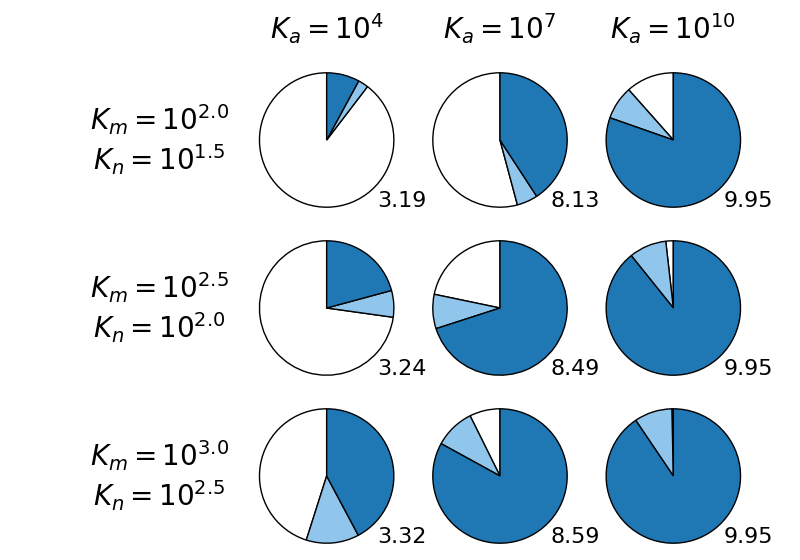

/Users/blandt/anaconda3/anaconda3/envs/membranequant/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


In [5]:
kas = [4, 7, 10]
kms = [2.0, 2.5, 3.0]

fig, ax = plt.subplots(3, 3)
for i, ka in enumerate(kas):
    for j, km in enumerate(kms):
        pie_panel(ax[j][i], ka=10 ** ka, kn=10 ** (km - 0.5), km=10 ** km)

ax[0][0].set_title(r'$K_a = 10^{%s}$' % kas[0], fontsize=10) 
ax[0][1].set_title(r'$K_a = 10^{%s}$' % kas[1], fontsize=10) 
ax[0][2].set_title(r'$K_a = 10^{%s}$' % kas[2], fontsize=10) 
ax[0][0].set_ylabel(r'$K_m = 10^{%s}$' % kms[0] + '\n' + r'$K_n = 10^{%s}$' % (kms[0] - 0.5), 
                    rotation=0, ha='center', va='center', labelpad=30) 
ax[1][0].set_ylabel(r'$K_m = 10^{%s}$' % kms[1] + '\n' + r'$K_n = 10^{%s}$' % (kms[1] - 0.5), 
                    rotation=0, ha='center', va='center', labelpad=30) 
ax[2][0].set_ylabel(r'$K_m = 10^{%s}$' % kms[2] + '\n' + r'$K_n = 10^{%s}$' % (kms[2] - 0.5), 
                    rotation=0, ha='center', va='center', labelpad=30) 

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig('Figs/pie_eq.png', dpi=600, transparent=True)